# Demo for equiPy

## What its all about
A short demonstration on how to use _equipy_ on a set of real data.

Here, we use data derived from the US census using the [folktables](https://github.com/socialfoundations/folktables) package, freely available. Our goal is to render predictions of log income fair, with respect to demographic parity. 

We fit a very simple gradient boosting machine on the data and then compare:
* Fairness and performance of the optimal (unfair) predictor $f^*$ vs the fair estimator wrt. _race_
* Fairness and performance of $f^*$ vs the fair estimator wrt. _race_ **and** _gender_

## Prerequisits

This demo environment has the following packages installed:

1. equipy
2. lightgbm (for fitting)
3. folktables (to load the data set)
4. seaborn (for the kde plots)

Other dependencies should be covered in internal dependencies of _equipy_

You will also need to set your working directory below. 

## Suggestions and Comments

Feel free to share your thoughts and ideas to one of the authors 

In [1]:
import os
os.getcwd()

'/Users/agathefernandesmachado/Documents/PhD/equipy/demo'

In [2]:
# Change this to your local repository
#work_dir = '../'

In [3]:
# Some manipulations for the illustration
import numpy as np
import pandas as pd

# For the basemodel
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

# Viz
import matplotlib.pyplot as plt
import seaborn as sns

# EquiPy
#import equipy

import random

# Set the seed
random.seed(2025)

In [4]:
%load_ext autoreload 
%autoreload 2
from utils.dataloader import load_sunbelt_data
from utils.preprocessing import preprocess_census
from utils.evaluation import cv_early_stopping

In [5]:
# Load some benchmarking data, can be replaced by any
# other data set
#
# Here we only load data for california, florida and texas
# all large states but with differing economies
data_all = load_sunbelt_data(states=['FL', 'TX', 'CA'])

In [6]:
cat_features = ['OCCP', 'POBP', 'SCHL', 'RELP']

ret_dict =  preprocess_census(data=data_all,
                              target_feature='PINCP',
                              sensitive_features=['SEX', 'RAC1P_black'],
                              categorical_features=cat_features,
                              continuous_features=['WKHP', 'AGEP'])

In [7]:
params = {
    "objective": "regression",
    "metric": "mse",
    "min_data_in_leaf": 50,
    "learning_rate": 0.05,
    "feature_fraction": 0.8,
    "verbose": -1
}

In [8]:
%%capture
cv_results = cv_early_stopping(params=params, 
                               nfolds=5, 
                               max_rounds=1000, 
                               early_stopping_rounds=20, 
                               X_train=ret_dict['X_train'], 
                               y_train=ret_dict['y_train'], 
                               categorical_feats=cat_features)

In [9]:
best_res = np.argmin(cv_results['metric'])
best_iter = cv_results['iterations'][best_res]

print((f"Best MSE: {np.min(cv_results['metric'])} \nBest Iter: {best_iter}"))

Best MSE: 0.5458365158549343 
Best Iter: 461


In [10]:
# Retrain whole model
data_train_all = lgb.Dataset(data=ret_dict['X_train'], 
                             label=ret_dict['y_train'], 
                             categorical_feature=cat_features)

best_estimator = lgb.train(params=params,
                           train_set=data_train_all, 
                           num_boost_round=best_iter)

In [11]:
pred_calib = best_estimator.predict(ret_dict['X_calib'])
pred_calib_1 = pred_calib[np.where(ret_dict['X_calib'].RAC1P_black == 1)[0]]
pred_calib_2 = pred_calib[np.where(ret_dict['X_calib'].RAC1P_black == 0)[0]]

In [12]:
pred_test = best_estimator.predict(ret_dict['X_test'])
pred_test_1 = pred_test[np.where(ret_dict['X_test'].RAC1P_black == 1)[0]]
pred_test_2 = pred_test[np.where(ret_dict['X_test'].RAC1P_black == 0)[0]]

<Axes: ylabel='Density'>

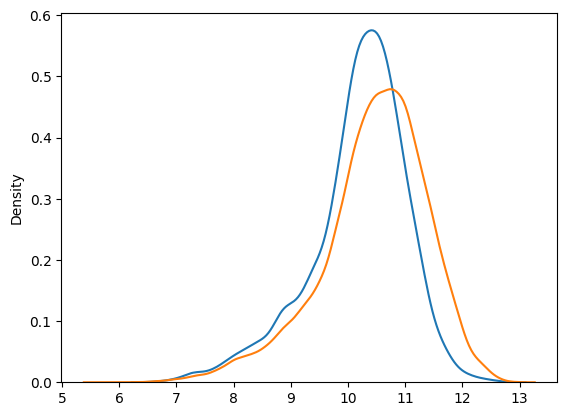

In [13]:
sns.kdeplot(pred_test_1)
sns.kdeplot(pred_test_2)

# Usage of Equipy for a Single Sensitive Attribute (SSA)

Here, we demonstrate how the _equipy_ package can be used to mitigate the unfairness in the predictions. 

In general, _equipy_ follows the logic of scikit-learn, where the mitigation method is a class that is first instantiated and then `fit()`-ted on training data to be used in the `tranform()` step on the test-set. 

See also the documentation for both 
* [FairWasserstein](https://equilibration.github.io/equipy/equipy.fairness.html#equipy.fairness.FairWasserstein)
* [unfairness](https://equilibration.github.io/equipy/equipy.metrics.html#equipy.metrics.unfairness)

In [14]:
# Change this to your local repository
#work_dir = '..'
#os.chdir(work_dir)

In [15]:
from equipy.fairness import FairWasserstein
from equipy.metrics import unfairness, performance

In [16]:
sens_calib = pd.DataFrame({'ethnicity': np.where(ret_dict['X_calib'].RAC1P_black == 1, 1, 0)})
sens_test = pd.DataFrame({'ethnicity': np.where(ret_dict['X_test'].RAC1P_black == 1, 1, 0)})

In [17]:
print("Unfairness in the initial predictions: ", unfairness(pred_test, sens_test))
print("Performance in the initial predictions: ", performance(ret_dict['y_test'].values, pred_test))

Unfairness in the initial predictions:  0.4419280344553851
Performance in the initial predictions:  0.5430811143493351


In [18]:
calibrator = FairWasserstein(sigma=0.0001)
calibrator.fit(pred_calib, sens_calib)
fair_pred = calibrator.transform(pred_test, sens_test)

In [19]:
print("Unfairness in the fair predictions for Origin: ", unfairness(fair_pred, sens_test))
print("Performance in the fair predictions for Origin: ", performance(ret_dict['y_test'].values, fair_pred))

Unfairness in the fair predictions for Origin:  0.08389152059610794
Performance in the fair predictions for Origin:  0.5503419846625848


In [20]:
from equipy.graphs import fair_density_plot, fair_arrow_plot, fair_waterfall_plot, fair_multiple_arrow_plot

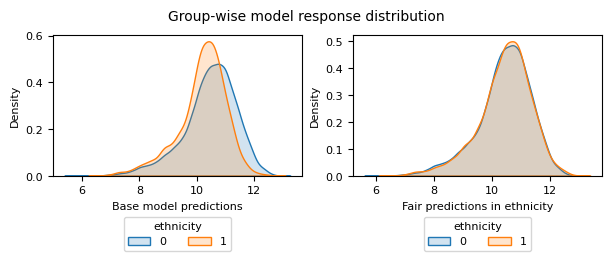

In [21]:
fig, ax = fair_density_plot(sens_calib, 
                  sens_test, 
                  pred_calib, 
                  pred_test,
                  figsize = (6,2.5))
fig.savefig("density_ssa.pdf", bbox_inches="tight")
plt.show()

(<Figure size 400x300 with 1 Axes>,
 <Axes: title={'center': 'Exact fairness'}, xlabel='Unfairness', ylabel='Performance'>)

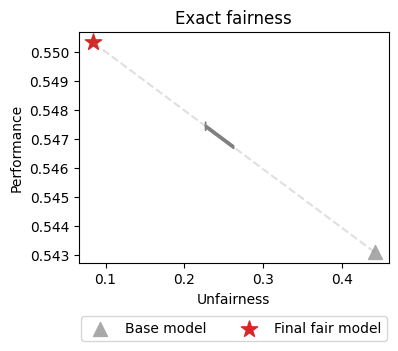

In [22]:
fair_arrow_plot(
    sens_calib,
    sens_test,
    pred_calib,
    pred_test,
    ret_dict['y_test'].values,
    figsize = (4,3))

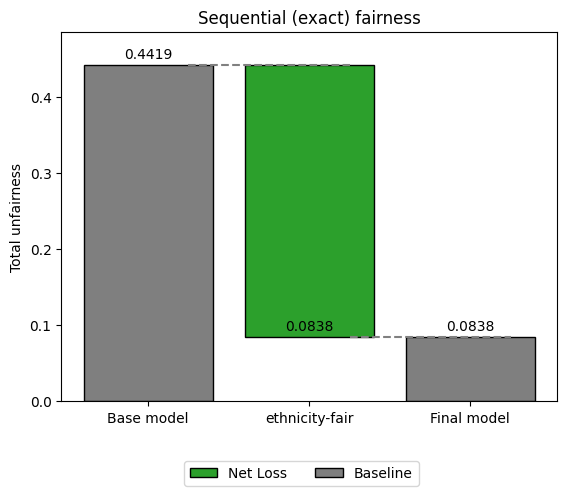

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Sequential (exact) fairness'}, ylabel='Total unfairness'>)

In [23]:
fair_waterfall_plot(sens_calib, sens_test, pred_calib, pred_test)

# Usage of Equipy for Multiple Sensitive Attributes (MSA)

Here, we demonstrate how the _equipy_ package can be used to mitigate the unfairness in the predictions. 

In general, _equipy_ follows the logic of scikit-learn, where the mitigation method is a class that is first instantiated and then `fit()`-ted on training data to be used in the `tranform()` step on the test-set. 

See also the documentation for both 
* [MultiWasserstein](https://equilibration.github.io/equipy/equipy.fairness.html#equipy.fairness.MultiWasserstein)
* [unfairness](https://equilibration.github.io/equipy/equipy.metrics.html#equipy.metrics.unfairness)

In [24]:
sens_calib_twovar = pd.DataFrame({
    'sex': np.where(ret_dict['X_calib'].SEX_2 == 1, 1, 0), 
    'ethnicity': np.where(ret_dict['X_calib'].RAC1P_black == 1, 1, 0)
})

sens_test_twovar = pd.DataFrame({
    'sex': np.where(ret_dict['X_test'].SEX_2 == 1, 1, 0),
    'ethnicity': np.where(ret_dict['X_test'].RAC1P_black == 1, 1, 0)
})

In [25]:
print("Unfairness in the initial predictions: ", unfairness(pred_test, sens_test_twovar))
print("Performance in the initial predictions: ", performance(ret_dict['y_test'].values, pred_test))

Unfairness in the initial predictions:  0.7895150074009543
Performance in the initial predictions:  0.5430811143493351


In [26]:
from equipy.fairness import MultiWasserstein
calibrator_ssa = MultiWasserstein(sigma=0.0001)
calibrator_ssa.fit(pred_calib, sens_calib_twovar[['sex']])
fair_pred_ssa = calibrator_ssa.transform(pred_test, sens_test_twovar[['sex']])

In [27]:
print("Unfairness in sex for the initial predictions: ", unfairness(pred_test, sens_test_twovar[['sex']]))
print("Unfairness in ethnicity for the initial predictions: ", unfairness(pred_test, sens_test_twovar[['ethnicity']]))
print("Unfairness in sex for the fair predictions w.r.t. sex: ", unfairness(fair_pred_ssa, sens_test_twovar[['sex']]))
print("Unfairness in ethnicity for the fair predictions w.r.t. sex: ", unfairness(fair_pred_ssa, sens_test_twovar[['ethnicity']]))

Unfairness in sex for the initial predictions:  0.3475869729455692
Unfairness in ethnicity for the initial predictions:  0.4419280344553851
Unfairness in sex for the fair predictions w.r.t. sex:  0.031108822596571883
Unfairness in ethnicity for the fair predictions w.r.t. sex:  0.3357350296380357


In [28]:
from equipy.fairness import MultiWasserstein
calibrator_msa = MultiWasserstein(sigma=0.0001)
calibrator_msa.fit(pred_calib, sens_calib_twovar)
fair_pred_msa = calibrator_msa.transform(pred_test, sens_test_twovar)

Since we consider multiple features, the initially fair predictions might not achieve the global fairness criteria in this case

In [30]:
print("Unfairness in the fair predictions for ethnicity and sex: ", unfairness(fair_pred_msa, sens_test_twovar))
print("Performance in the fair predictions for ethnicity and sex: ", performance(ret_dict['y_test'].values, fair_pred_msa))

Unfairness in the fair predictions for ethnicity and sex:  0.11932776695658731
Performance in the fair predictions for ethnicity and sex:  0.5867876845109514


In [31]:
# Calculate sequential unfairness
y_seq_fair = calibrator_msa.y_fair
print(f"Unfairness before mitigation: {unfairness(y_seq_fair['Base model'], sens_test_twovar):.3f}")
print(f"Unfairness after mitigating biases from sex: {unfairness(y_seq_fair['sex'], sens_test_twovar):.3f}")
print(f"Unfairness after mitigating biases from sex and ethnicity: {unfairness(y_seq_fair['ethnicity'], sens_test_twovar):.3f}")

Unfairness before mitigation: 0.790
Unfairness after mitigating biases from sex: 0.405
Unfairness after mitigating biases from sex and ethnicity: 0.119


In [32]:
# Calculate sequential unfairness in each sensitive variable
print(f"Unfairness in sex before mitigation: {unfairness(y_seq_fair['Base model'], sens_test_twovar[['sex']]):.3f}")
print(f"Unfairness in ethnicity before mitigation: {unfairness(y_seq_fair['Base model'], sens_test_twovar[['ethnicity']]):.3f}")
print(f"Unfairness in sex after mitigation w.r.t. sex: {unfairness(y_seq_fair['sex'], sens_test_twovar[['sex']]):.3f}")
print(f"Unfairness in ethnicity after mitigation w.r.t. sex: {unfairness(y_seq_fair['sex'], sens_test_twovar[['ethnicity']]):.3f}")
print(f"Unfairness in sex after mitigation w.r.t. sex and ethnicity: {unfairness(y_seq_fair['ethnicity'], sens_test_twovar[['sex']]):.3f}")
print(f"Unfairness in ethnicity after mitigation w.r.t. sex and ethnicity: {unfairness(y_seq_fair['ethnicity'], sens_test_twovar[['ethnicity']]):.3f}")

Unfairness in sex before mitigation: 0.348
Unfairness in ethnicity before mitigation: 0.442
Unfairness in sex after mitigation w.r.t. sex: 0.026
Unfairness in ethnicity after mitigation w.r.t. sex: 0.379
Unfairness in sex after mitigation w.r.t. sex and ethnicity: 0.032
Unfairness in ethnicity after mitigation w.r.t. sex and ethnicity: 0.088


(<Figure size 2600x1800 with 9 Axes>,
 array([[<Axes: xlabel='Base model predictions', ylabel='Density'>,
         <Axes: xlabel='Fair predictions in sex', ylabel='Density'>,
         <Axes: xlabel='Fair predictions in ethnicity', ylabel='Density'>],
        [<Axes: xlabel='Base model predictions', ylabel='Density'>,
         <Axes: xlabel='Fair predictions in sex', ylabel='Density'>,
         <Axes: xlabel='Fair predictions in ethnicity', ylabel='Density'>],
        [<Axes: xlabel='Base model predictions', ylabel='Density'>,
         <Axes: xlabel='Fair predictions in sex', ylabel='Density'>,
         <Axes: xlabel='Fair predictions in ethnicity', ylabel='Density'>]],
       dtype=object))

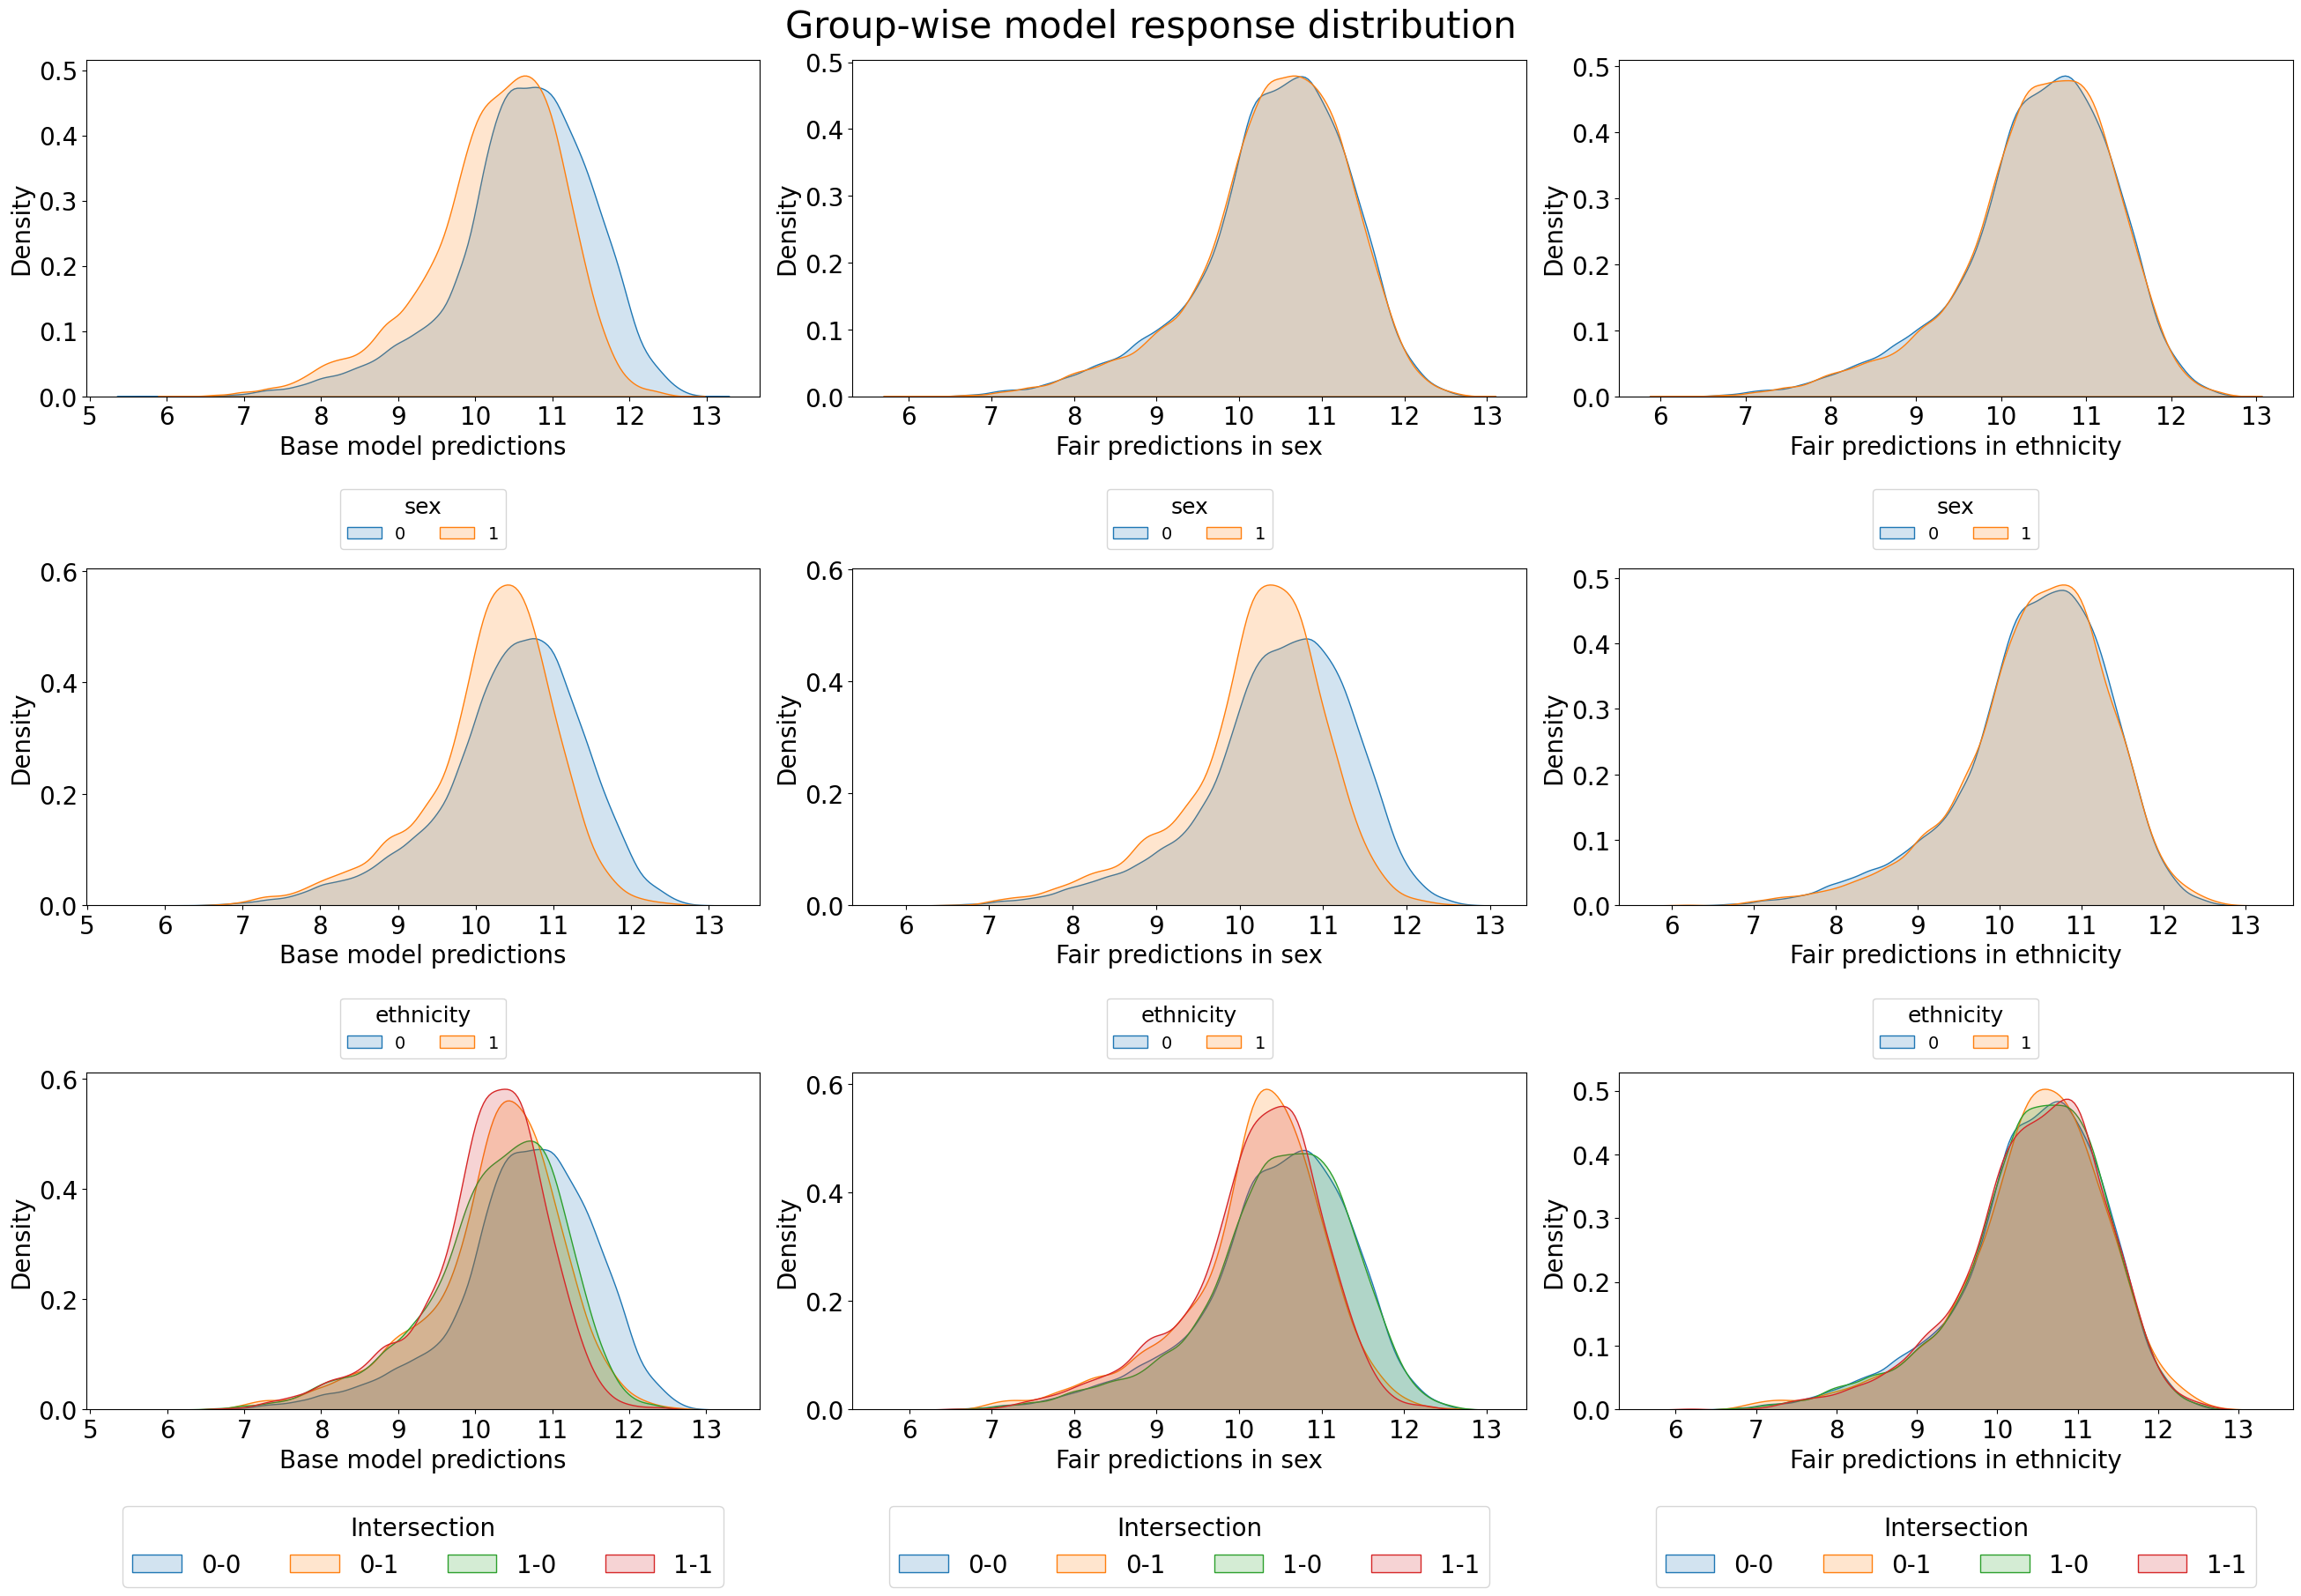

In [37]:
fair_density_plot(sens_calib_twovar,
                  sens_test_twovar,
                  pred_calib,
                  pred_test)

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Exact fairness'}, xlabel='Unfairness', ylabel='Performance'>)

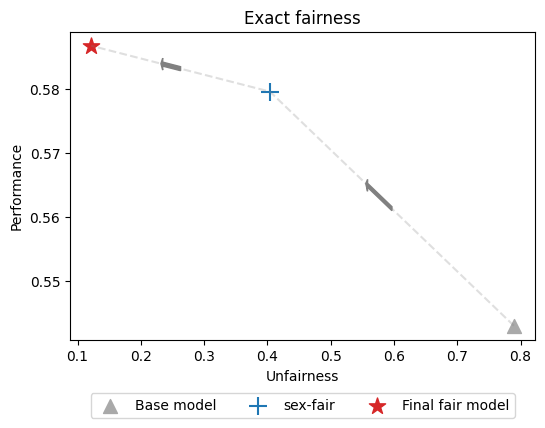

In [34]:
fair_arrow_plot(sens_calib_twovar, 
                sens_test_twovar, 
                pred_calib, 
                pred_test,
                ret_dict['y_test'].values,
                figsize = (6,4))

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Exact fairness'}, xlabel='Unfairness', ylabel='Performance'>)

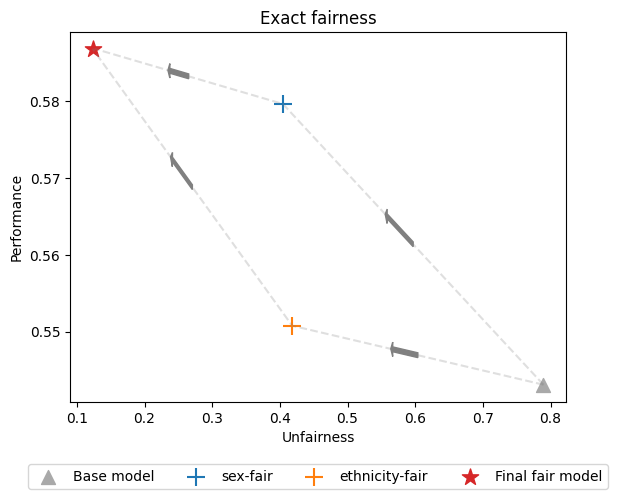

In [36]:
#from equipy.graphs import fair_multiple_arrow_plot
fair_multiple_arrow_plot(sens_calib_twovar, 
                sens_test_twovar, 
                pred_calib, 
                pred_test,
                ret_dict['y_test'].values,
                figsize = (4,3)
                )

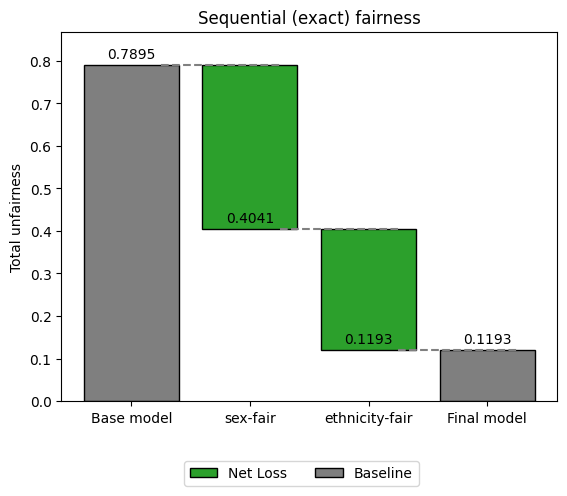

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Sequential (exact) fairness'}, ylabel='Total unfairness'>)

In [38]:
fair_waterfall_plot(sens_calib_twovar, 
                sens_test_twovar, 
                pred_calib, 
                pred_test
                )

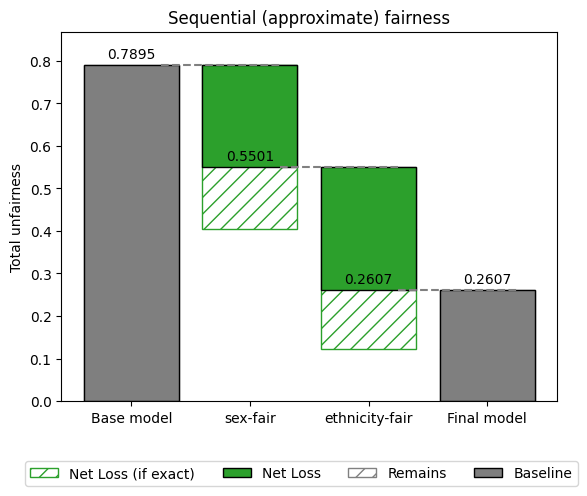

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Sequential (approximate) fairness'}, ylabel='Total unfairness'>)

In [39]:
fair_waterfall_plot(sens_calib_twovar, 
                sens_test_twovar, 
                pred_calib, 
                pred_test,
                epsilon=[0.5, 0.25])

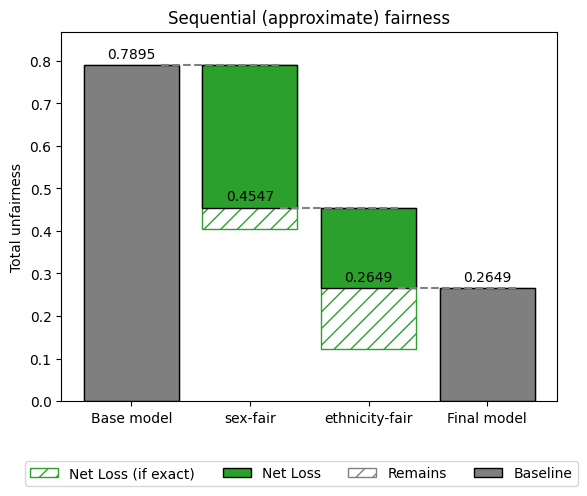

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Sequential (approximate) fairness'}, ylabel='Total unfairness'>)

In [40]:
fair_waterfall_plot(sens_calib_twovar, 
                sens_test_twovar, 
                pred_calib, 
                pred_test,
                epsilon=[0.25, 0.5])

In [41]:
sens_calib_twovar_order = sens_calib_twovar[['ethnicity', 'sex']]
sens_test_twovar_order = sens_test_twovar[['ethnicity', 'sex']]

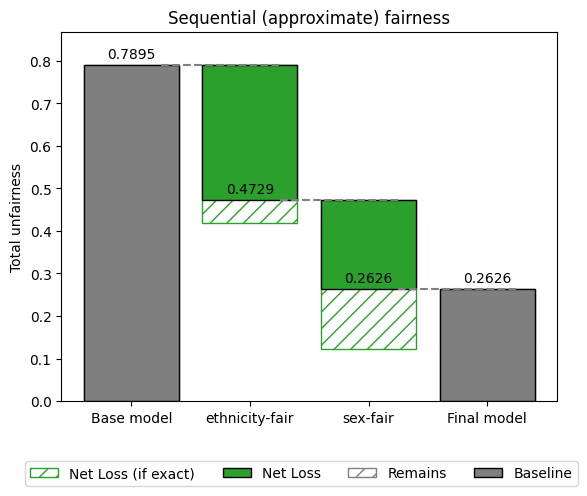

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Sequential (approximate) fairness'}, ylabel='Total unfairness'>)

In [42]:
fair_waterfall_plot(sens_calib_twovar_order, 
                sens_test_twovar_order, 
                pred_calib, 
                pred_test,
                epsilon=[0.25, 0.5])

## Check for intersectional fairness

In [43]:
# Create one sensitive attribute with 4 categories from A1 and A2
mapping = {
    (0, 0): '00',
    (0, 1): '01',
    (1, 0): '10',
    (1, 1): '11'
}

# Apply the mapping
int_sens_calib = sens_calib_twovar.apply(lambda row: mapping[(row['ethnicity'], row['sex'])], axis=1)
int_sens_test= sens_test_twovar.apply(lambda row: mapping[(row['ethnicity'], row['sex'])], axis=1)

int_sens_calib = pd.DataFrame(int_sens_calib, columns=['int'])
int_sens_test = pd.DataFrame(int_sens_test, columns=['int'])

In [44]:
calibrator_int = FairWasserstein(sigma=0.001)
calibrator_int.fit(pred_calib, int_sens_calib)
fair_pred_int = calibrator_int.transform(pred_test, int_sens_test)

In [45]:
unfairness(pred_test, int_sens_test), unfairness(fair_pred_int, int_sens_test)

(np.float64(0.6024124373597086), np.float64(0.16725179971560244))

In [46]:
calibrator_int = MultiWasserstein(sigma=0.0001)
calibrator_int.fit(pred_calib, int_sens_calib)
fair_pred_int = calibrator_int.transform(pred_test, int_sens_test)

In [47]:
unfairness(pred_test, int_sens_test), unfairness(fair_pred_int, int_sens_test)

(np.float64(0.6024124373597086), np.float64(0.16716102095105256))

(<Figure size 600x250 with 2 Axes>,
 array([<Axes: xlabel='Base model predictions', ylabel='Density'>,
        <Axes: xlabel='Fair predictions in int', ylabel='Density'>],
       dtype=object))

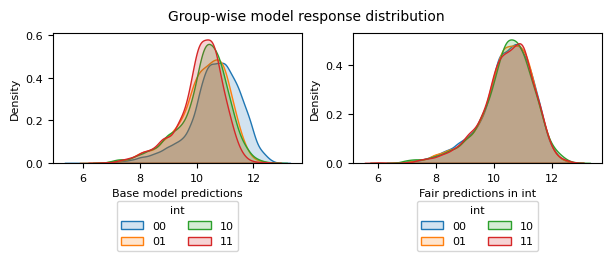

In [48]:
fair_density_plot(int_sens_calib,
                  int_sens_test,
                  pred_calib,
                  pred_test,
                  figsize = (6,2.5))